In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/test-questions/ActsQuestions.csv
/kaggle/input/test-questions-version2/uhaki_questions_balanced_v1.csv
/kaggle/input/roberta76-v1/transformers/default/1/robertaClassifiercls76%/config.json
/kaggle/input/roberta76-v1/transformers/default/1/robertaClassifiercls76%/merges.txt
/kaggle/input/roberta76-v1/transformers/default/1/robertaClassifiercls76%/tokenizer.json
/kaggle/input/roberta76-v1/transformers/default/1/robertaClassifiercls76%/vocab.json
/kaggle/input/roberta76-v1/transformers/default/1/robertaClassifiercls76%/tokenizer_config.json
/kaggle/input/roberta76-v1/transformers/default/1/robertaClassifiercls76%/model.safetensors
/kaggle/input/roberta76-v1/transformers/default/1/robertaClassifiercls76%/special_tokens_map.json
/kaggle/input/roberta76-v1/transformers/default/1/robertaClassifiercls76%/id2label.json
/kaggle/input/legal-queries/allQuestions.csv
/kaggle/input/combineddataset/combined_dataset.csv


In [4]:
import os, json, random
from collections import Counter

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    Trainer,
    TrainingArguments,
)

from datasets import Dataset as HFDataset
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [10]:
csv_files = [
    "/kaggle/input/legal-queries/allQuestions.csv",
    "/kaggle/input/test-questions/ActsQuestions.csv",
    "/kaggle/input/test-questions-version2/uhaki_questions_balanced_v1.csv"
]

dfs = []

In [11]:
for file in csv_files:
    if os.path.exists(file):
        print(f"Loading: {file}")
        df = pd.read_csv(file)
        dfs.append(df)
    else:
        print(f" File not found: {file}")

if not dfs:
    raise ValueError(" No CSVs loaded. Check file paths.")

Loading: /kaggle/input/legal-queries/allQuestions.csv
Loading: /kaggle/input/test-questions/ActsQuestions.csv
Loading: /kaggle/input/test-questions-version2/uhaki_questions_balanced_v1.csv


In [12]:
combined_df = pd.concat(dfs, ignore_index=True)

combined_df.drop_duplicates(subset=["question", "act"], inplace=True)
combined_df.dropna(subset=["question", "act"], inplace=True)

combined_df = combined_df.sample(frac=1, random_state=42).reset_index(drop=True)

output_path = "/kaggle/working/combined_dataset.csv"
combined_df.to_csv(output_path, index=False, encoding="utf-8-sig")

In [13]:
output_path = "/kaggle/working/combined_dataset.csv"
combined_df.to_csv(output_path, index=False, encoding="utf-8-sig")

print(f" Combined dataset saved to: {output_path}")
print(f"Total rows: {len(combined_df)}")
print(combined_df.head())

 Combined dataset saved to: /kaggle/working/combined_dataset.csv
Total rows: 5572
                                            question                      act
0  Charge shall, on receiving a written request m...                 Land Act
1  If any person or State organ has authority und...    Constitution of Kenya
2  What may happen if a police officer or other p...  Criminal Procedure Code
3  What is the purpose of subsection (7) for the ...           Income Tax Act
4  What is the name of the county executive commi...    Constitution of Kenya


In [14]:
print(f" Combined dataset saved to: {output_path}")
print(f"Total rows: {len(combined_df)}")
print(combined_df.head())

 Combined dataset saved to: /kaggle/working/combined_dataset.csv
Total rows: 5572
                                            question                      act
0  Charge shall, on receiving a written request m...                 Land Act
1  If any person or State organ has authority und...    Constitution of Kenya
2  What may happen if a police officer or other p...  Criminal Procedure Code
3  What is the purpose of subsection (7) for the ...           Income Tax Act
4  What is the name of the county executive commi...    Constitution of Kenya


In [16]:
MODEL_PATH = "/kaggle/input/roberta76-v1/transformers/default/1/robertaClassifiercls76%"

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH).eval()
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [17]:
id2label = getattr(model.config, "id2label", None)
if isinstance(id2label, dict):
    id2label = {int(k): v for k, v in id2label.items()}  
if not id2label or not isinstance(id2label, dict) or not id2label:
    sidecar = os.path.join(MODEL_PATH, "id2label.json")
    if os.path.exists(sidecar):
        with open(sidecar, "r", encoding="utf-8") as f:
            id2label = {int(k): v for k, v in json.load(f).items()}  # your notebook saved this
    else:
        id2label = {i: f"CLASS_{i}" for i in range(model.config.num_labels)}

label2id = {v: k for k, v in id2label.items()}
num_labels = model.config.num_labels
print("Loaded labels:", len(id2label))

Loaded labels: 20


In [18]:
print(id2label)

{0: 'Children Act', 1: 'Constitution of Kenya', 2: 'Criminal Procedure Code', 3: 'Data Protection Act', 4: 'Distress for Rent Act', 5: 'Employment Act', 6: 'Evidence Act', 7: 'Excise Duty Act', 8: 'Fatal Accidents Act', 9: 'Income Tax Act', 10: 'Labour Relations Act', 11: 'Land Act', 12: 'Law of Contract Act', 13: 'Law of Succession Act', 14: 'Marriage Act', 15: 'Persons with Disabilities Act', 16: 'Small Claims Court Act', 17: 'Tax Procedures Act', 18: 'Value Added Tax Act', 19: 'Work Injury Benefits Act'}


In [30]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

COMBINED_CSV = "/kaggle/input/combineddataset/combined_dataset.csv"  
MODEL_PATH   = "/kaggle/input/roberta76-v1/transformers/default/1/robertaClassifiercls76%"
OUTPUT_DIR   = "/kaggle/working/robertaV2final"
MAX_LEN      = 256

In [6]:
df = pd.read_csv(COMBINED_CSV)

df = df[["question", "act"]].dropna().copy()
df["question"] = df["question"].astype(str).str.strip()
df["act"]      = df["act"].astype(str).str.strip()
df = df[(df["question"] != "") & (df["act"] != "")]
df = df.drop_duplicates(subset=["question", "act"]).reset_index(drop=True)

print(f"Total rows after clean: {len(df)}")
print("Class counts (top 20):", Counter(df["act"]).most_common(20))

Total rows after clean: 5572
Class counts (top 20): [('Criminal Procedure Code', 667), ('Children Act', 573), ('Income Tax Act', 567), ('Constitution of Kenya', 538), ('Land Act', 433), ('Tax Procedures Act', 317), ('Evidence Act', 302), ('Law of Succession Act', 279), ('Value Added Tax Act', 235), ('Employment Act', 234), ('Persons with Disabilities Act', 209), ('Labour Relations Act', 193), ('Excise Duty Act', 185), ('Work Injury Benefits Act', 183), ('Data Protection Act', 164), ('Marriage Act', 163), ('Small Claims Court Act', 118), ('Distress for Rent Act', 98), ('Fatal Accidents Act', 58), ('Law of Contract Act', 56)]


In [8]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model     = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)

id2label = getattr(model.config, "id2label", None)
if isinstance(id2label, dict) and len(id2label) > 0:
    id2label = {int(k): v for k, v in id2label.items()}
else:
    sidecar = os.path.join(MODEL_PATH, "id2label.json")
    if os.path.exists(sidecar):
        with open(sidecar, "r", encoding="utf-8") as f:
            id2label = {int(k): v for k, v in json.load(f).items()}
    else:
        id2label = {i: f"CLASS_{i}" for i in range(model.config.num_labels)}


In [9]:
label2id = {v: k for k, v in id2label.items()}

acts_in_data  = sorted(df["act"].unique())
acts_in_model = set(label2id.keys())

need_new_head = (not set(acts_in_data).issubset(acts_in_model)) or (len(acts_in_data) != model.config.num_labels)


In [10]:
if need_new_head:
    print("Adapting classification head to match dataset labels.")
    new_id2label = {i: lab for i, lab in enumerate(acts_in_data)}
    new_label2id = {lab: i for i, lab in new_id2label.items()}

    model = AutoModelForSequenceClassification.from_pretrained(
        MODEL_PATH,
        num_labels=len(new_id2label),
        ignore_mismatched_sizes=True
    )
    model.config.id2label = new_id2label
    model.config.label2id = new_label2id
    id2label, label2id = new_id2label, new_label2id
else:
    print("Reusing existing head and label set.")
    
    df = df[df["act"].isin(acts_in_model)].reset_index(drop=True)

df["label"] = df["act"].map(label2id)
print("Num labels:", len(label2id))

Reusing existing head and label set.
Num labels: 20


In [11]:
df_train, df_tmp = train_test_split(
    df, test_size=0.20, random_state=RANDOM_SEED, stratify=df["label"]
)
df_val, df_test = train_test_split(
    df_tmp, test_size=0.50, random_state=RANDOM_SEED, stratify=df_tmp["label"]
)

print(f"Train: {len(df_train)} | Val: {len(df_val)} | Test: {len(df_test)}")

Train: 4457 | Val: 557 | Test: 558


In [12]:
def tokenize_batch(batch):
    toks = tokenizer(
        batch["question"],
        truncation=True,
        max_length=MAX_LEN
    )
    toks["labels"] = batch["label"]
    return toks

train_ds = HFDataset.from_pandas(df_train[["question", "label"]].reset_index(drop=True)).map(tokenize_batch, batched=True)
val_ds   = HFDataset.from_pandas(df_val[["question", "label"]].reset_index(drop=True)).map(tokenize_batch, batched=True)
test_ds  = HFDataset.from_pandas(df_test[["question", "label"]].reset_index(drop=True)).map(tokenize_batch, batched=True)

for ds in (train_ds, val_ds, test_ds):
    ds.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Map:   0%|          | 0/4457 [00:00<?, ? examples/s]

Map:   0%|          | 0/557 [00:00<?, ? examples/s]

Map:   0%|          | 0/558 [00:00<?, ? examples/s]

In [13]:

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "f1_weighted": f1_score(labels, preds, average="weighted"),
    }


In [15]:
args_kwargs = dict(
    output_dir=OUTPUT_DIR,
    save_strategy="epoch",
    save_total_limit=2,
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    weight_decay=0.01,
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    fp16=torch.cuda.is_available(),
    report_to=[],
    seed=RANDOM_SEED
)

In [18]:
try:
    
    args = TrainingArguments(evaluation_strategy="epoch", **args_kwargs)
except TypeError:
   
    args = TrainingArguments(eval_strategy="epoch", **args_kwargs)


In [20]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)


/tmp/ipykernel_37/113346839.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [21]:
train_result = trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.716800,0.602625,0.829443,0.787610,0.829468
2,0.490600,0.538690,0.850987,0.826240,0.848408
3,0.373500,0.533785,0.852783,0.836025,0.851367


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [22]:
val_metrics = trainer.evaluate()
print("\n=== Validation metrics ===")
for k, v in val_metrics.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v}")

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



=== Validation metrics ===
eval_loss: 0.5338
eval_accuracy: 0.8528
eval_f1_macro: 0.8360
eval_f1_weighted: 0.8514
eval_runtime: 3.9775
eval_samples_per_second: 140.0360
eval_steps_per_second: 2.2630
epoch: 3.0000


In [26]:
pred = trainer.predict(test_ds)
y_true = pred.label_ids
y_pred = np.argmax(pred.predictions, axis=-1)

# Text report
inv_labels = id2label  # {id: name}
target_names = [inv_labels[i] for i in sorted(inv_labels.keys())]
print("\n=== Classification Report (TEST) ===")
print(classification_report(y_true, y_pred, target_names=target_names, digits=3))


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



=== Classification Report (TEST) ===
                               precision    recall  f1-score   support

                 Children Act      0.867     0.897     0.881        58
        Constitution of Kenya      0.862     0.926     0.893        54
      Criminal Procedure Code      0.877     0.955     0.914        67
          Data Protection Act      1.000     0.750     0.857        16
        Distress for Rent Act      0.889     0.889     0.889         9
               Employment Act      0.773     0.708     0.739        24
                 Evidence Act      0.848     0.933     0.889        30
              Excise Duty Act      0.778     0.778     0.778        18
          Fatal Accidents Act      1.000     1.000     1.000         5
               Income Tax Act      0.836     0.895     0.864        57
         Labour Relations Act      0.850     0.850     0.850        20
                     Land Act      0.867     0.886     0.876        44
          Law of Contract Act      1.0

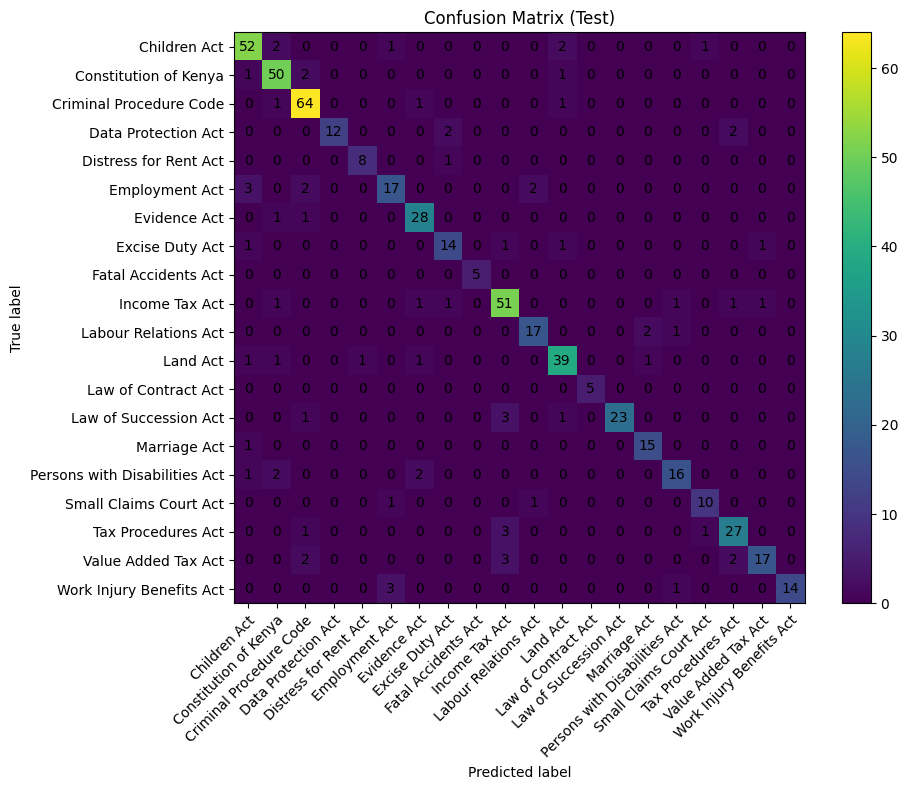

In [27]:
cm = confusion_matrix(y_true, y_pred, labels=sorted(inv_labels.keys()))
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(cm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)
ax.set(
    xticks=np.arange(len(target_names)),
    yticks=np.arange(len(target_names)),
    xticklabels=target_names, yticklabels=target_names,
    ylabel='True label',
    xlabel='Predicted label',
    title='Confusion Matrix (Test)'
)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout()
plt.show()

In [31]:
os.makedirs(OUTPUT_DIR, exist_ok=True)
trainer.save_model(OUTPUT_DIR)           
tokenizer.save_pretrained(OUTPUT_DIR)

with open(os.path.join(OUTPUT_DIR, "id2label.json"), "w", encoding="utf-8") as f:
    json.dump({int(k): v for k, v in id2label.items()}, f, ensure_ascii=False, indent=2)

with open(os.path.join(OUTPUT_DIR, "label2id.json"), "w", encoding="utf-8") as f:
    json.dump({v: int(k) for k, v in id2label.items()}, f, ensure_ascii=False, indent=2)

print(f" Saved model and label maps to: {OUTPUT_DIR}")

 Saved model and label maps to: /kaggle/working/robertaV2final


In [32]:
import shutil


model_path = "/kaggle/working/robertaV2final"      
output_filename = "/kaggle/working/robertaV2zipped2"  

shutil.make_archive(output_filename, 'zip', model_path)

print(" Model zipped successfully as", output_filename + ".zip")


 Model zipped successfully as /kaggle/working/robertaV2zipped2.zip
